3 single member complexes removed
recalculating on largest connected component.
There are 113 component(s).
The top largest component sizes are Any[1739, 22, 17, 13, 13, 13, 12, 11, 11, 10].
There is 0 singleton component(s).
New hypergraph has 558 weighted edges.
Hypergraph has 1739 nodes and 558 edges containing 558 set(s).
Nodes essential: 693 Edges essential: 230
Creating mappings for function set A_B_summary 
________________________________________________
5%: 34 proteins
max number of TP proteins: 31 for 2 set(s): Any["P:(0,1,0,1)", "P:(1/95,95,1,1/95)"]
---------------------------------------------------------
10%: 69 proteins
max number of TP proteins: 56 for 1 set(s): Any["P:(1,1,46,29/46)"]
---------------------------------------------------------
25%: 173 proteins
max number of TP proteins: 136 for 1 set(s): Any["P:(1,1,46,29/46)"]
---------------------------------------------------------
50%: 346 proteins
max number of TP proteins: 178 for 1 set(s): Any["P:(1,1,46,29/46)"]

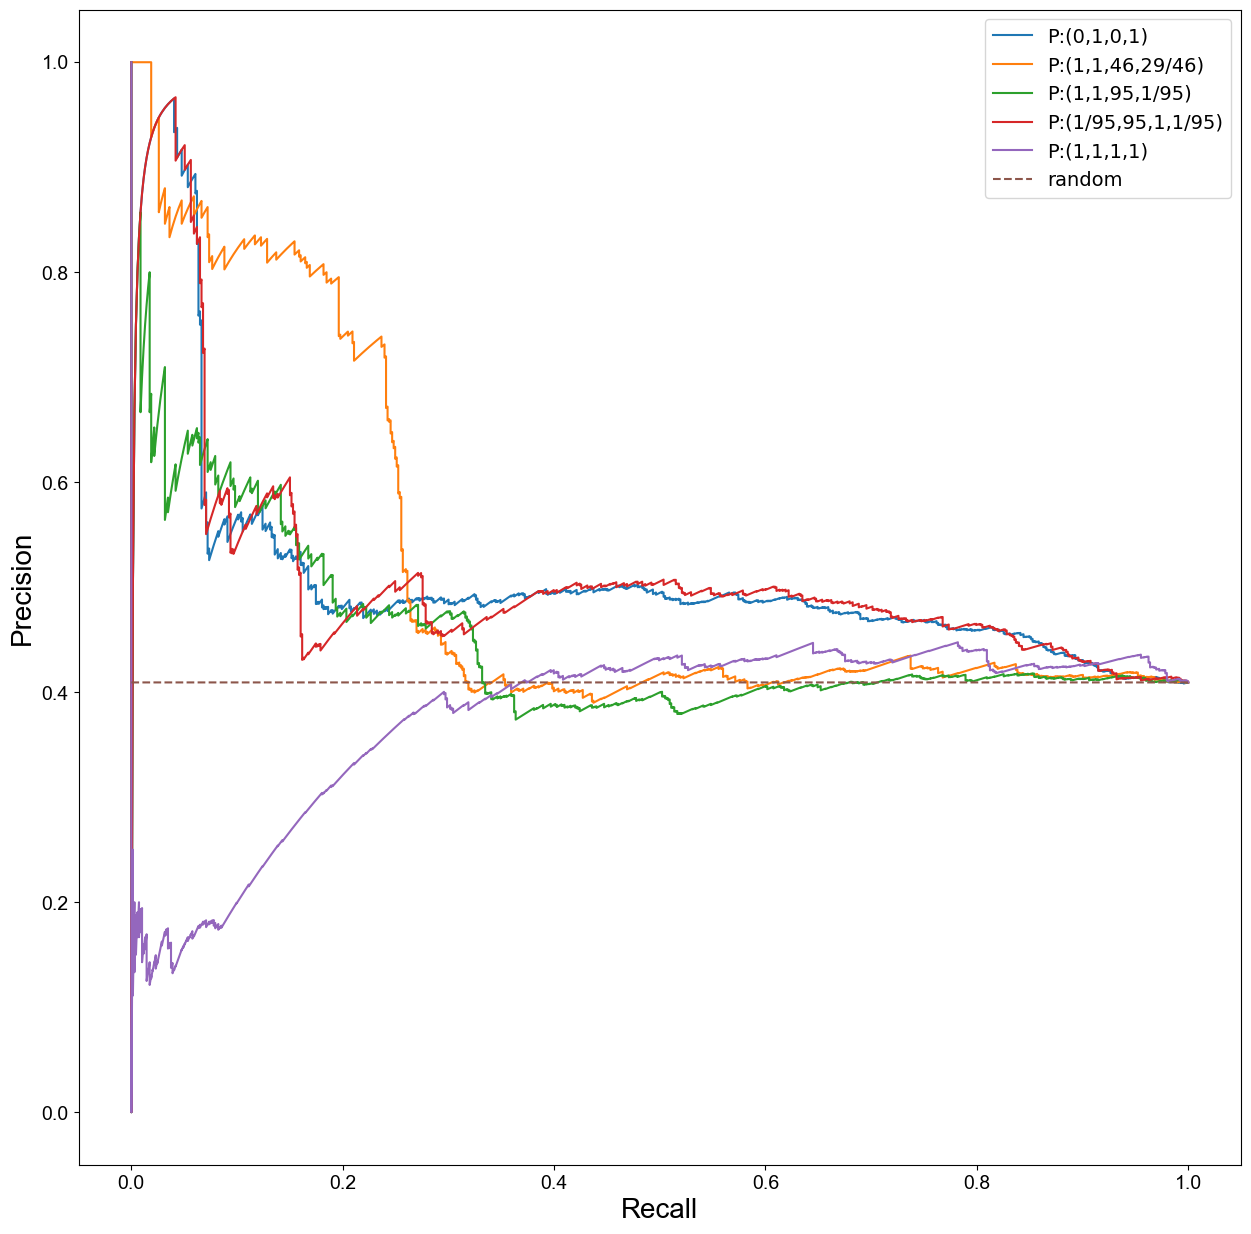

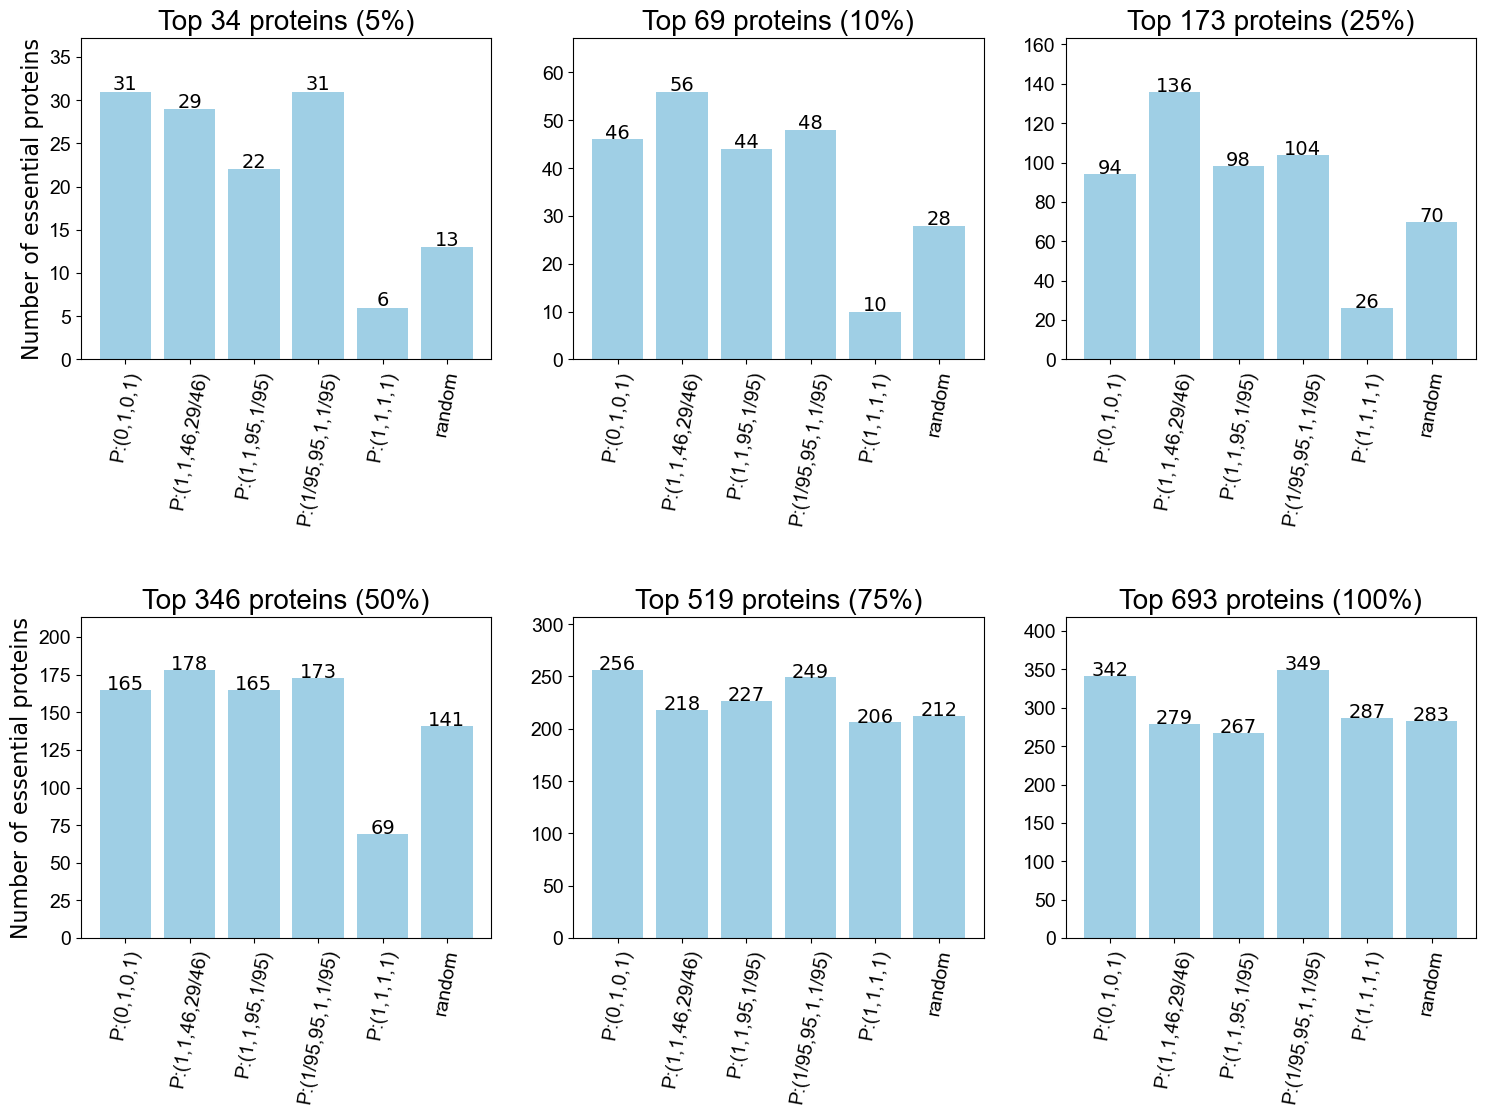

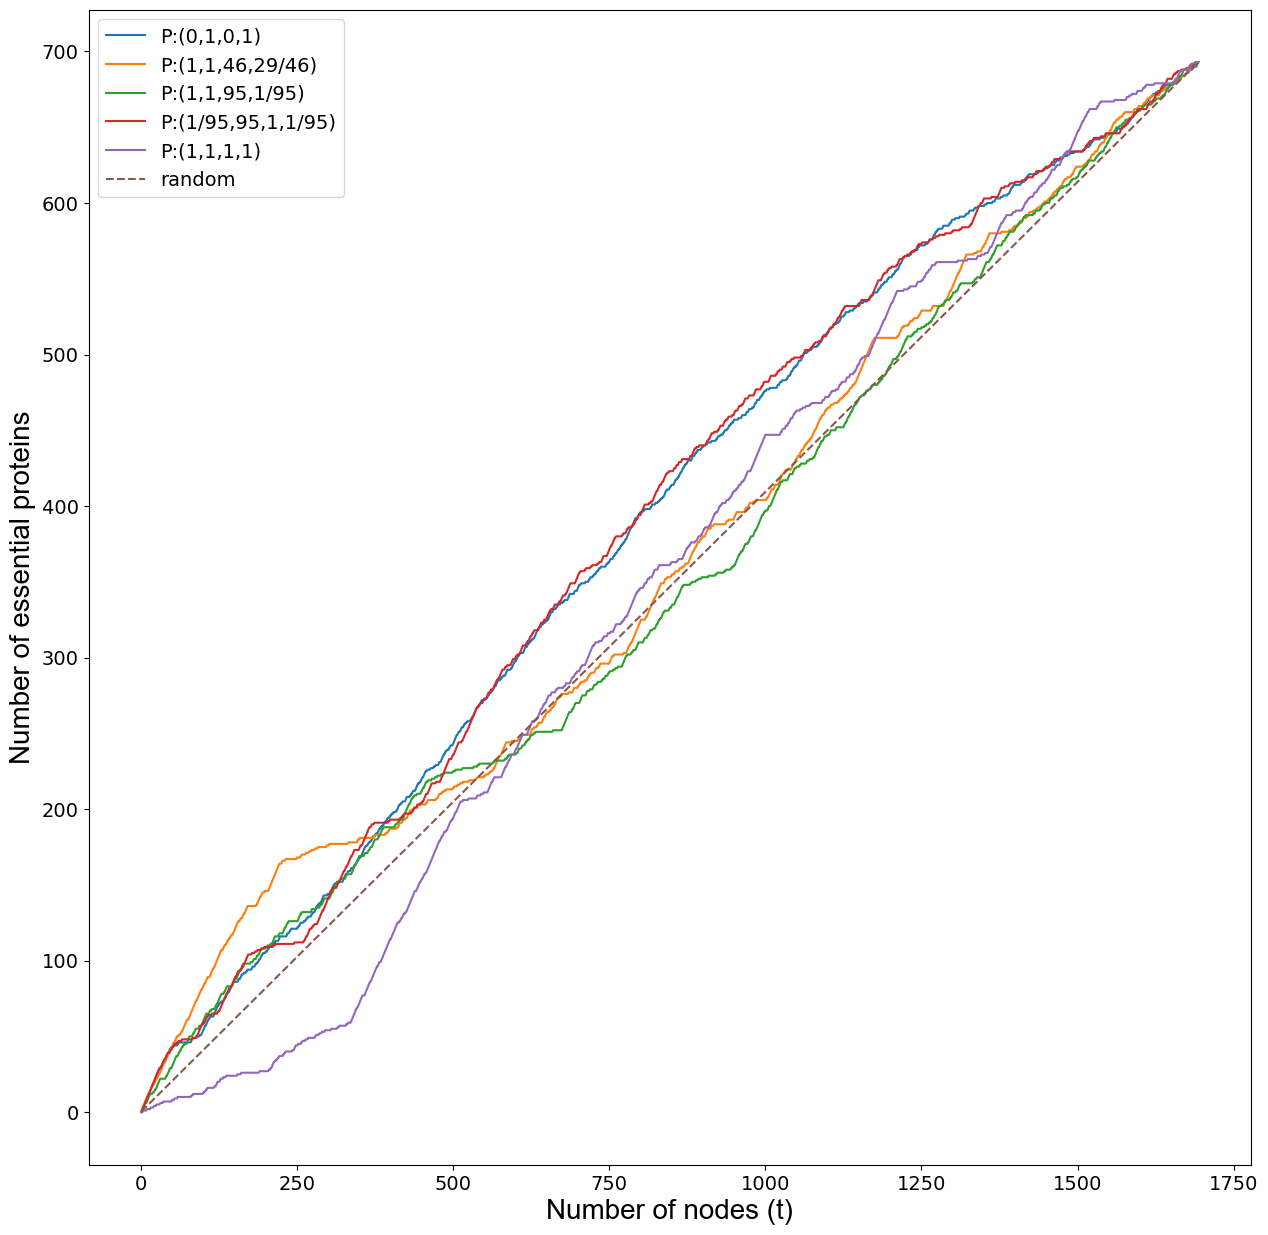

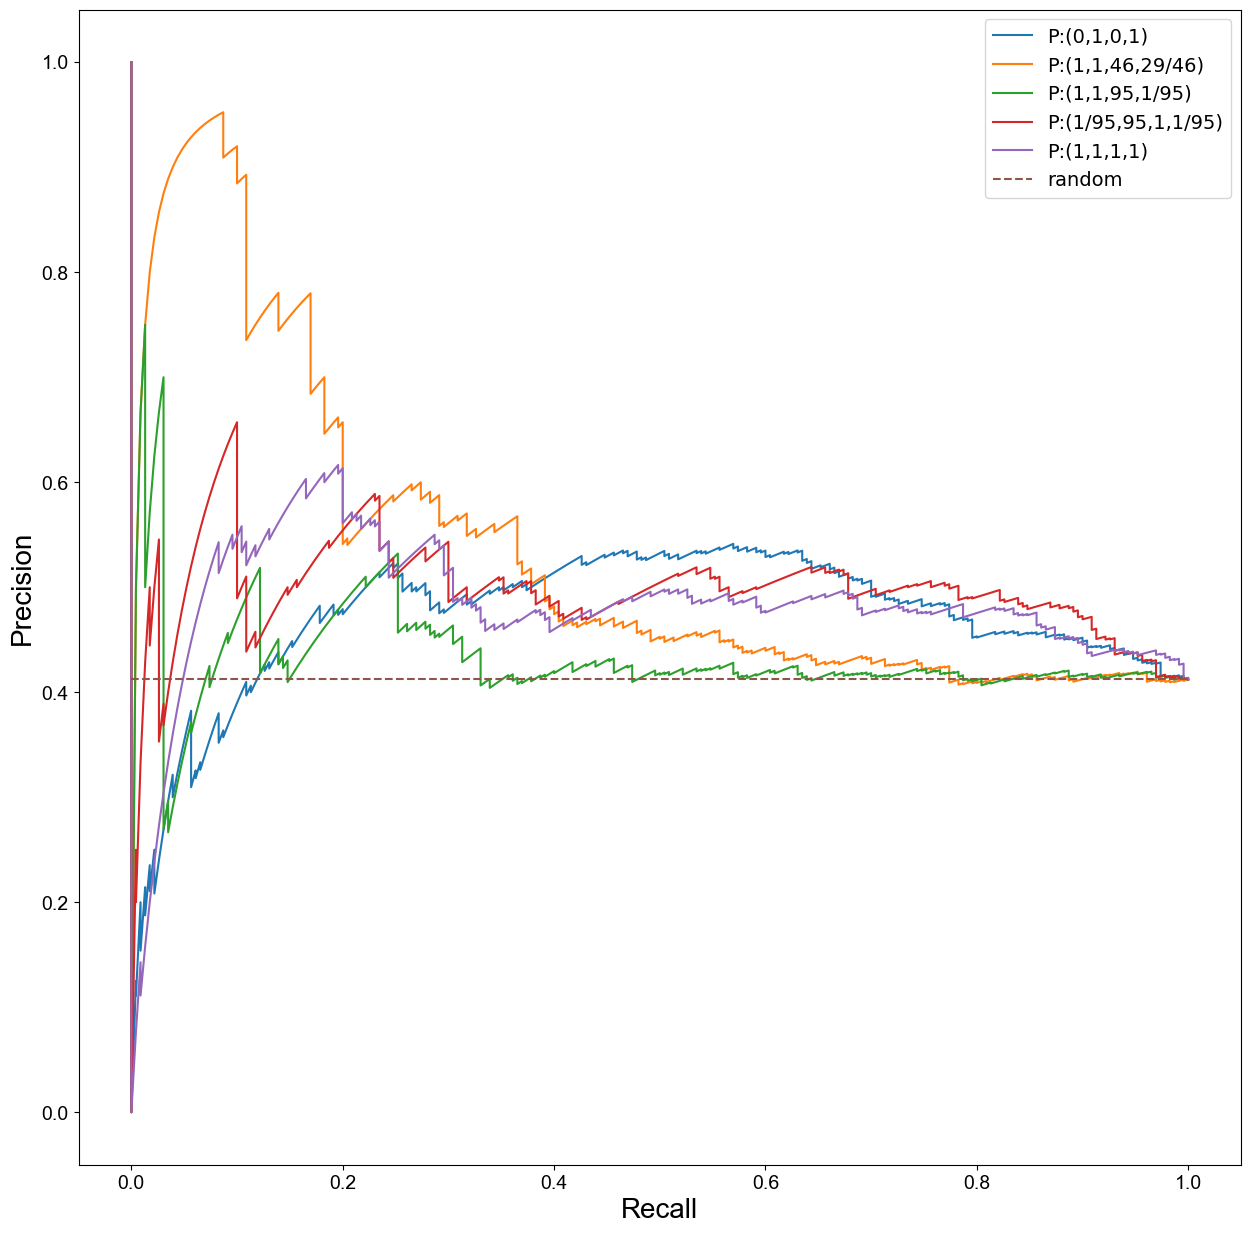

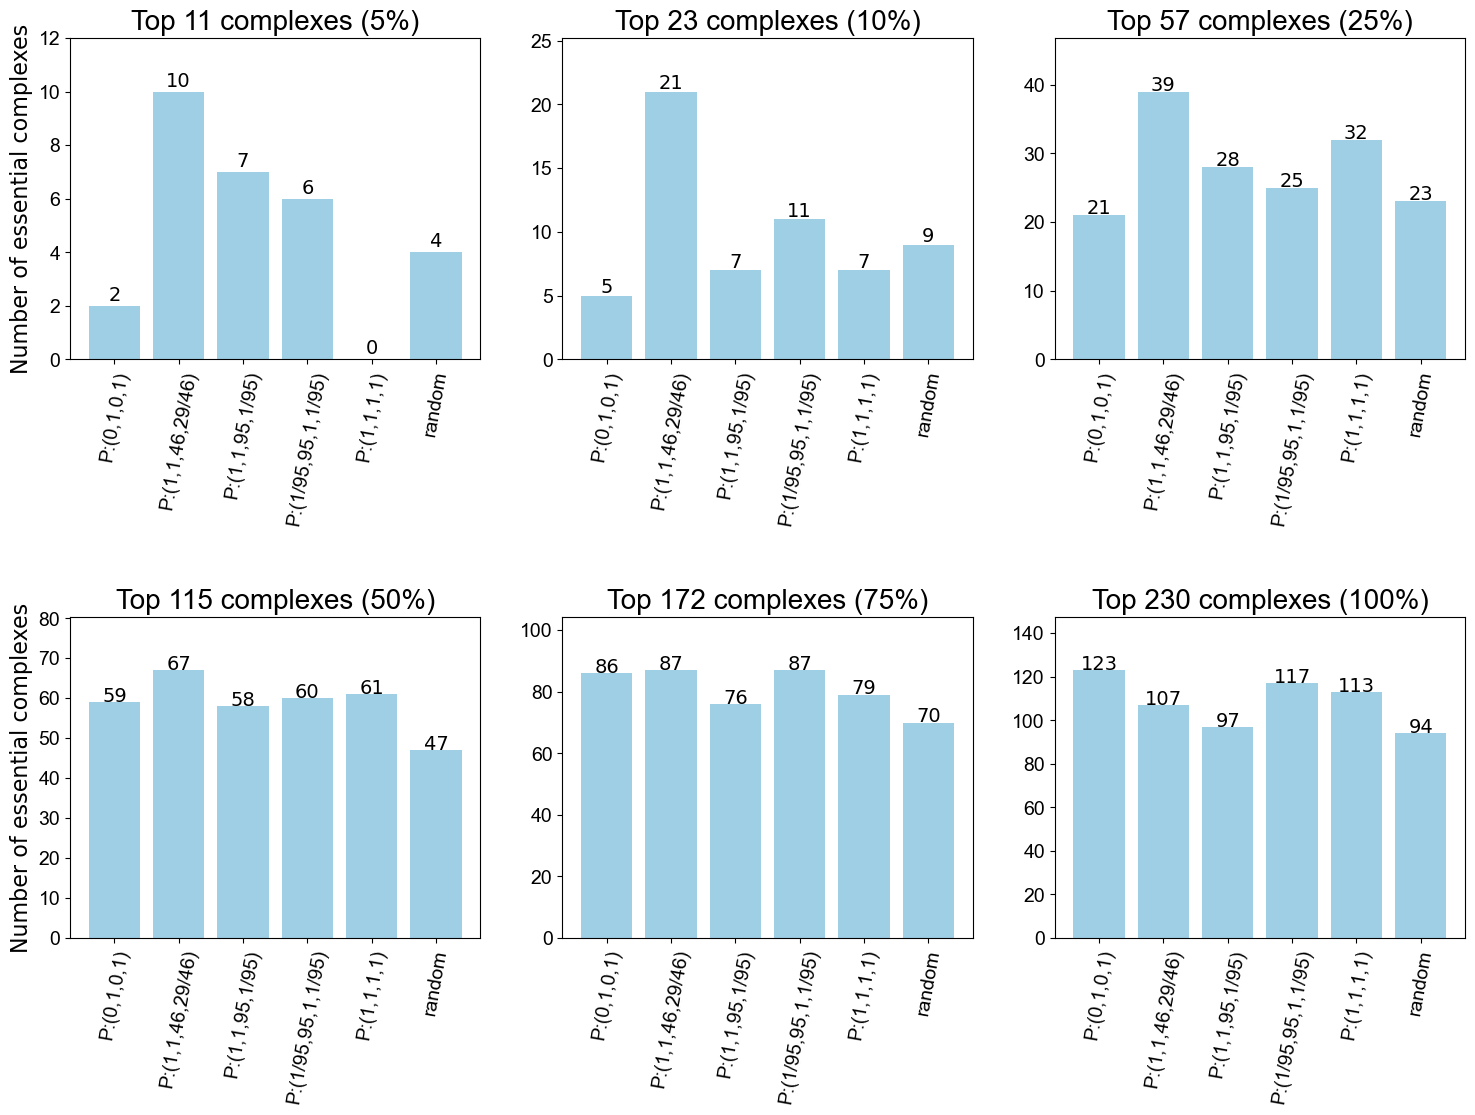

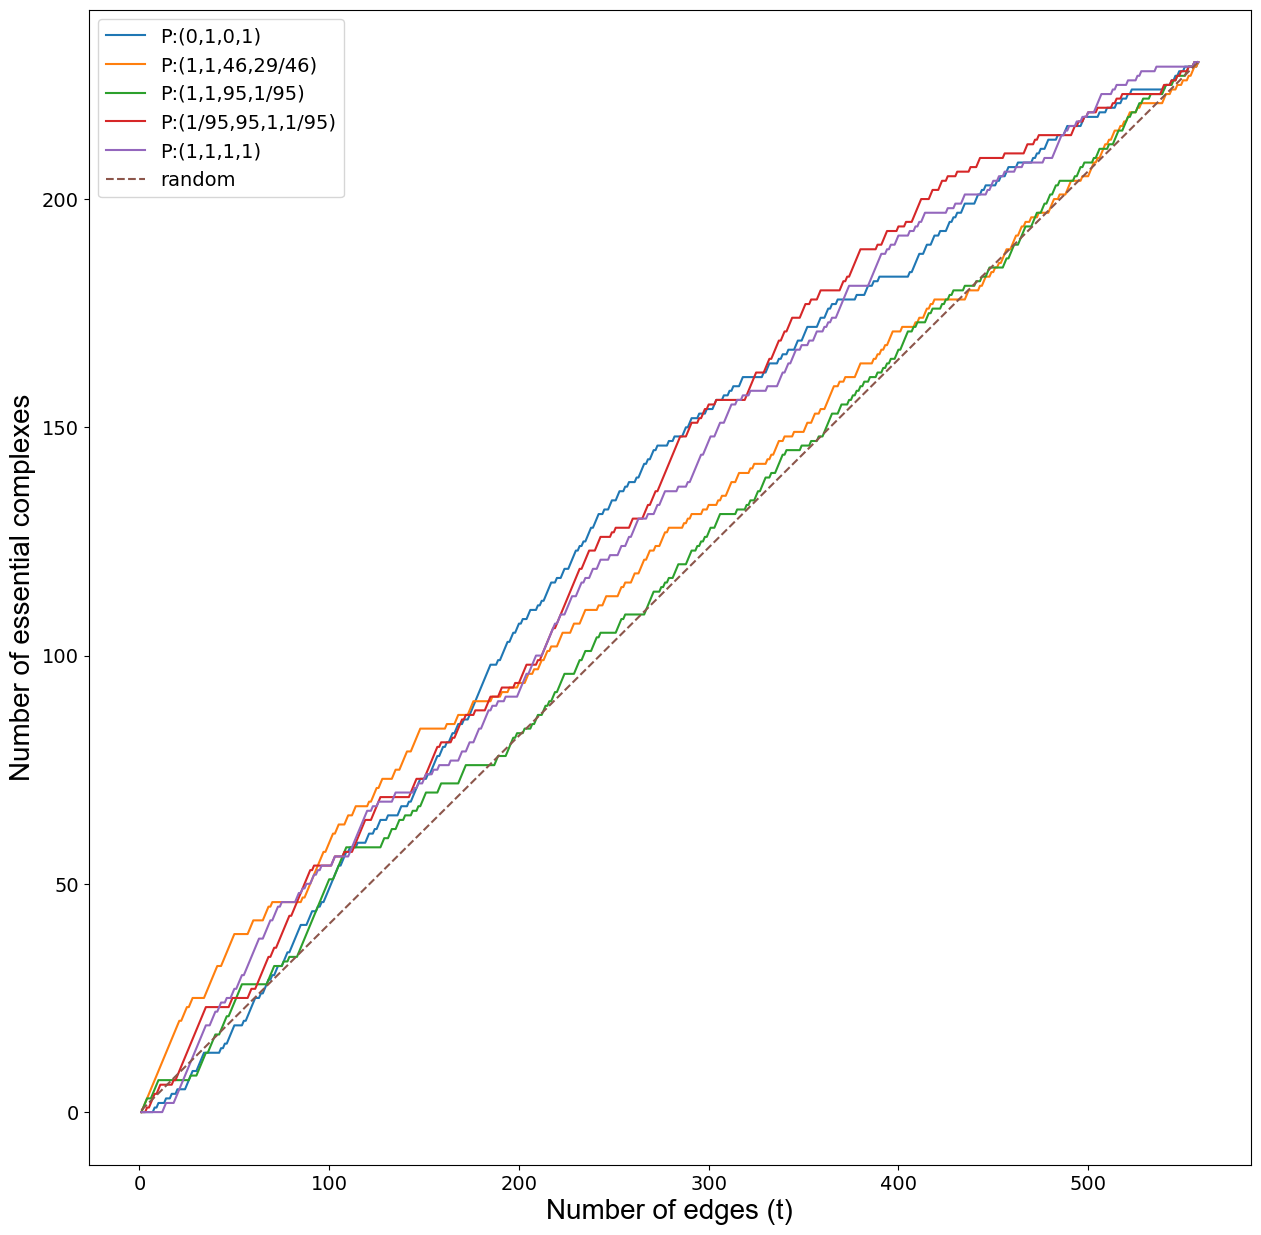

In [3]:
#DELETE OUTPUTS AND RESTART KERNAL BEFORE RUNNING
#RUN THIS FILE TO REPORUDCE RESULTS FROM 
#"An application of node and edge nonlinear hypergrpah centrality to a protein complex hypernetwork." Lawson, S., Donovan, D., Lefevre,J. School of Mathematics and Physics, University of Queensland 2024 (unpublished). 
using JLD2 
using SparseArrays
using StatsBase
using PyPlot
using Plots
using SimpleHypergraphs
using Trapz
using Graphs
using LinearAlgebra
using EvalMetrics
using Combinatorics
using DelimitedFiles

#not sure if used:
# using Statistics
# using HypothesisTests
# using Shuffle
# using Metrics
# using FileIO


file_path = "C:\\Users\\sarit\\RA_code\\NSVC_git_repo\\PCH_node_edge_centrality" #file path for code folder
output_path = "$file_path\\Outputs" #output folder for text files and plots
include("$file_path\\data_processing_functions.jl")
include("$file_path\\mappings_initialization.jl") 
include("$file_path\\compute_centrality_functions.jl")
include("$file_path\\analysis_functions.jl") 
include("$file_path\\helper_functions.jl") 
include("$file_path\\plot_functions.jl") 
include("$file_path\\high_performance.jl") 

#CHOOSE FUNCTION SETS - COMMENT OUT ALL FUNCTION SETS OTHER THAN ONE NEEDED  
varying = 
#"setA"
#"setB_summary"
"A_B_summary"

# "1_1_c_k/c"   #Full set of c, d=k/c for c,k in range 0.1:95  presaved as setA_1_1_c_kc_centralities-load below
# "setB_complete" #   #Full set B centralitites for a,b,c,d presaved as setB_comb_0_1_195_95_centralities-load below

#Algorithm parameters
max_iterations = 800
tolerance = 1e-6

#percentage of essential proteins as edge essentiality criteria:

e_percentage = 0.6  #at least 60% essential proteins in complex


#6 percentage thresholds 
percent_threshold = [0.05, 0.10, 0.25, 0.50, 0.75, 1.0];


#Process yeast complexes and essentiality data:
dataset_name = "yeast_protein"
name_title = "Yeast Protein Complexes"
file = "$file_path\\yeast_raw_data\\raw_complex_yeast.txt"
essential = "$file_path\\yeast_raw_data\\essential_proteins_yeast.txt"
nonessential = "$file_path\\yeast_raw_data\\nonessential_proteins_yeast.txt"
set_dict = yeast_complexes_set_dict(file) #create dictionary of complexes from raw file

#Remove single member sets from set_dict:
s = 0
for i in keys(set_dict)
    if length(set_dict[i]) == 1
        delete!(set_dict, i)
        s += 1
    end
end
println(s, " single member complexes removed")

#create text files to outputs folder and a dict with key:node name and value: node number. 
node_numbers_dict = data_processing(set_dict, dataset_name, output_path)


##############################################################################################################
#CREATE HYPERGRAPH
B, w, edgesx, edges_fromB, node_names_list, connected = read_hypergraph_data(
    dataset_name,
    output_path,
    max_iterations = max_iterations,
    tolerance = tolerance,
);

if !connected
    #recaluclate for largest connected component:
    #save original data:
    orig_w = w
    orig_B = B
    orig_edges_fromB = edges_fromB
    orig_set_dict = set_dict
    orig_node_numbers_dict = node_numbers_dict
    orig_node_names_list = node_names_list
    orig_edges = edgesx
    println("recalculating on largest connected component.")
    B, w, edgesx, edges_fromB, node_names_list, set_dict, dataset_name, node_numbers_dict =
        max_component_recalculate(B, node_numbers_dict, set_dict, dataset_name)

end

#count nodes, edges and original sets
no_nodes = size(B)[1]
no_edges = size(B)[2]
no_sets = Int(sum(w))

println(
    "Hypergraph has $no_nodes nodes and $no_edges edges containing $no_sets set(s).",
)

#dictionary containing key:node, value:list of edges node belongs to 
node_edges_dict = node_in_edges(node_numbers_dict, edges_fromB)

#dictionary containing key:edge number value:original sets represented
edge_number_dict = edge_numbers_dict(node_numbers_dict)

#create dictionary of node and edge degrees
ia = false #if ia = false then does not include max_edge, node adjacency, mean_deg in degree_centralities
deg_centralities, edge_deg_centralities =
    deg_centralities_dict(B, node_edges_dict, edges_fromB, edge_weights = w, inc_adj = ia)

#create dictionary of nodes and edge essentiality status and print number of essential/nonessential nodes/edges
node_ess_dict, unk, n_essent, n_non_essent =
    node_class_dict(node_names_list, essential, nonessential, printlines = false)

edge_ess_dict, e_essent, e_non_essent = edge_class_dict(
    node_ess_dict,
    edges_fromB,
    node_names_list,
    printlines = false,
    per_ess = e_percentage,
);

println("Nodes essential: ", n_essent, " Edges essential: ", e_essent)

#################################################################################################################
#Create or load centrality dictionary. 


centralities, ranked_nodes_dict, ranked_edges_dict, mappings =
    initialization(varying); #centralitites based on 'varying' parameter

#for efficiency, large centralitity dictionaries have been saved and can be preloaded.
#centralities=load_object("setA_1_1_c_kc_centralities.jld2") #centralitites for functions of the form P:(1,1,c,k/c) for c,k in range 0.1:95
#centralities=load_object("setB_comb_0_1_195_95_centralities.jld2") #centralitites for functions of the form P:(a,b,c,d) with a,c in {0,1,95,1/95} and b,d in {1,95,1/95}}

#print summary of maximum true positives for centralities
println("________________________________________________")
for cent_type in ["x", "y"]
    for i in percent_threshold
        max_true_pos(
            cent_type,
            centralities,
            i,
            n_essent,
            e_essent,
            n_non_essent,
            e_non_essent,
            node_ess_dict,
            edge_ess_dict;
            printlines = false,
            reverse = true,
        )
    end

    println("________________________________________________")

end


#comment out the following if centrality dictionary is large
# print summary of AUC and create plots

for cent_type in ["x", "y"]
    measures_dict = all_class_measures_plots(
        cent_type,
        centralities,
        deg_centralities,
        edge_deg_centralities,
        n_essent,
        n_non_essent,
        node_ess_dict,
        e_essent,
        e_non_essent,
        edge_ess_dict,
        percent_threshold,
        printlines = false,
        varying = varying,
    )
end
#######################################################################################################

##print out max auc for node and edge high performers for setA_1_1_c_kc_centralities.jld2 and setB_comb_0_1_195_95_centralities.jld2

#high_peform(n_essent, n_non_essent, e_essent, e_non_essent, node_ess_dict,edge_ess_dict)


 

cent_type  x
AUC for P:(0,1,0,1) is 0.5065707437480113
AUC for P:(1,1,46,29/46) is 0.5189385570681866
AUC for P:(1,1,95,1/95) is 0.45006825253288435
AUC for P:(1/95,95,1,1/95) is 0.5085439678648993
AUC for P:(1,1,1,1) is 0.37690089059735477
cent_type  y
AUC for P:(0,1,0,1) is 0.46839087894751724
AUC for P:(1,1,46,29/46) is 0.5306592137582669
AUC for P:(1,1,95,1/95) is 0.4308115020267103
AUC for P:(1/95,95,1,1/95) is 0.4947168642011055
AUC for P:(1,1,1,1) is 0.4804497055848954


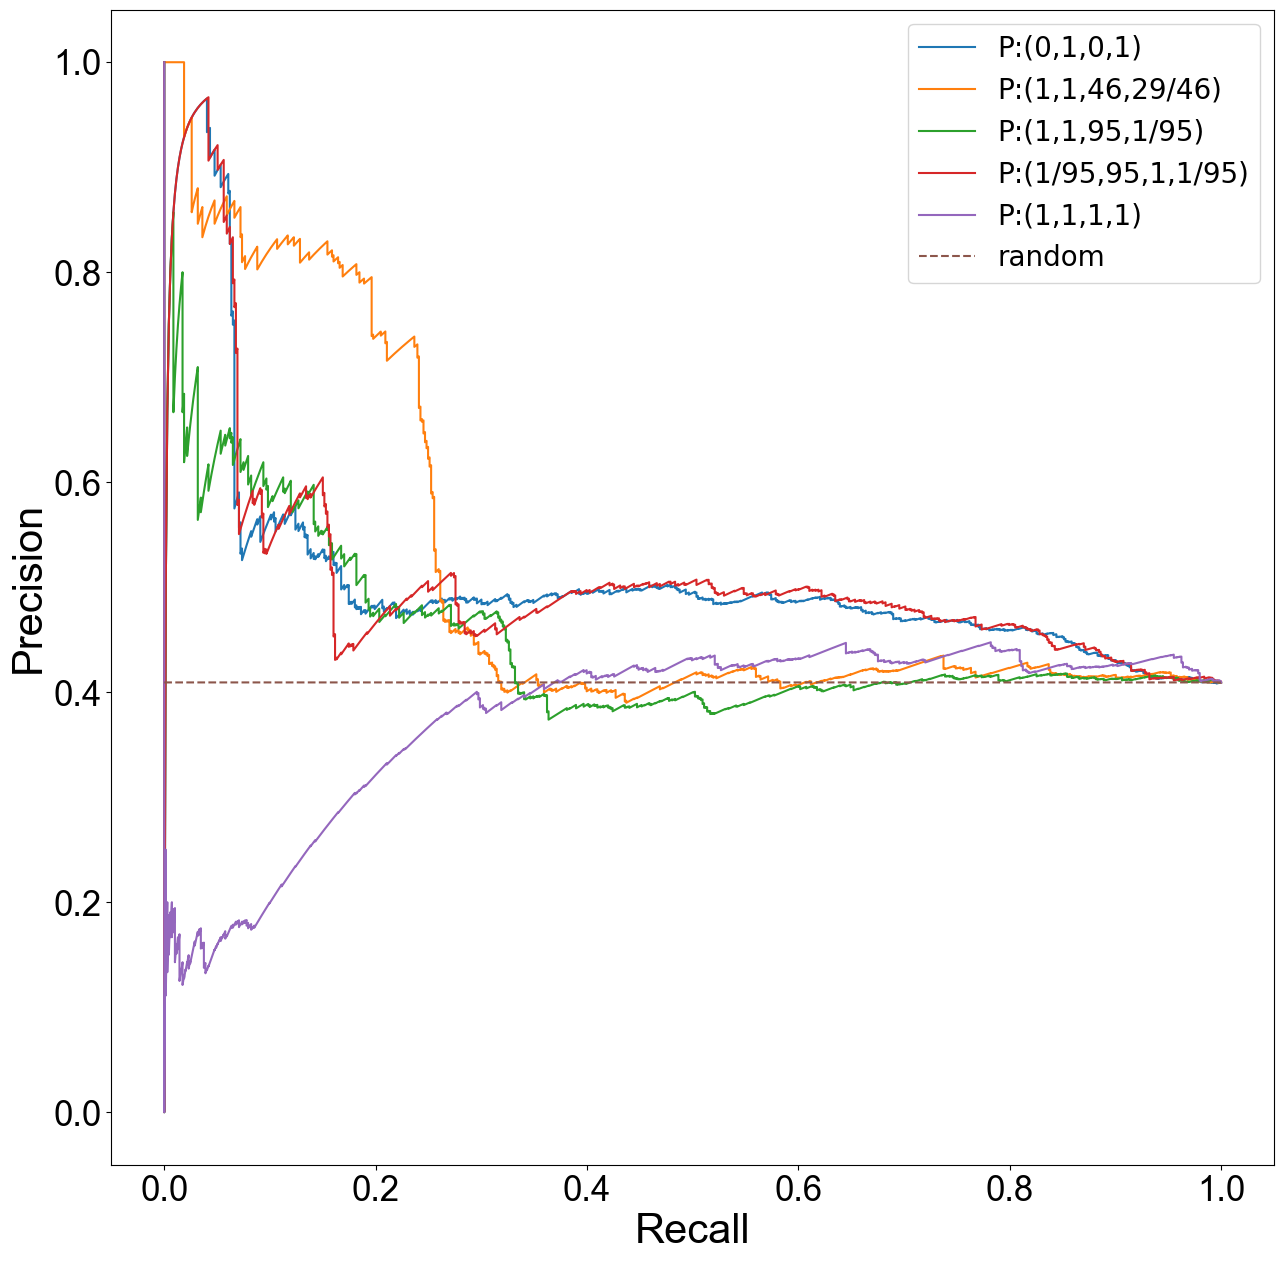

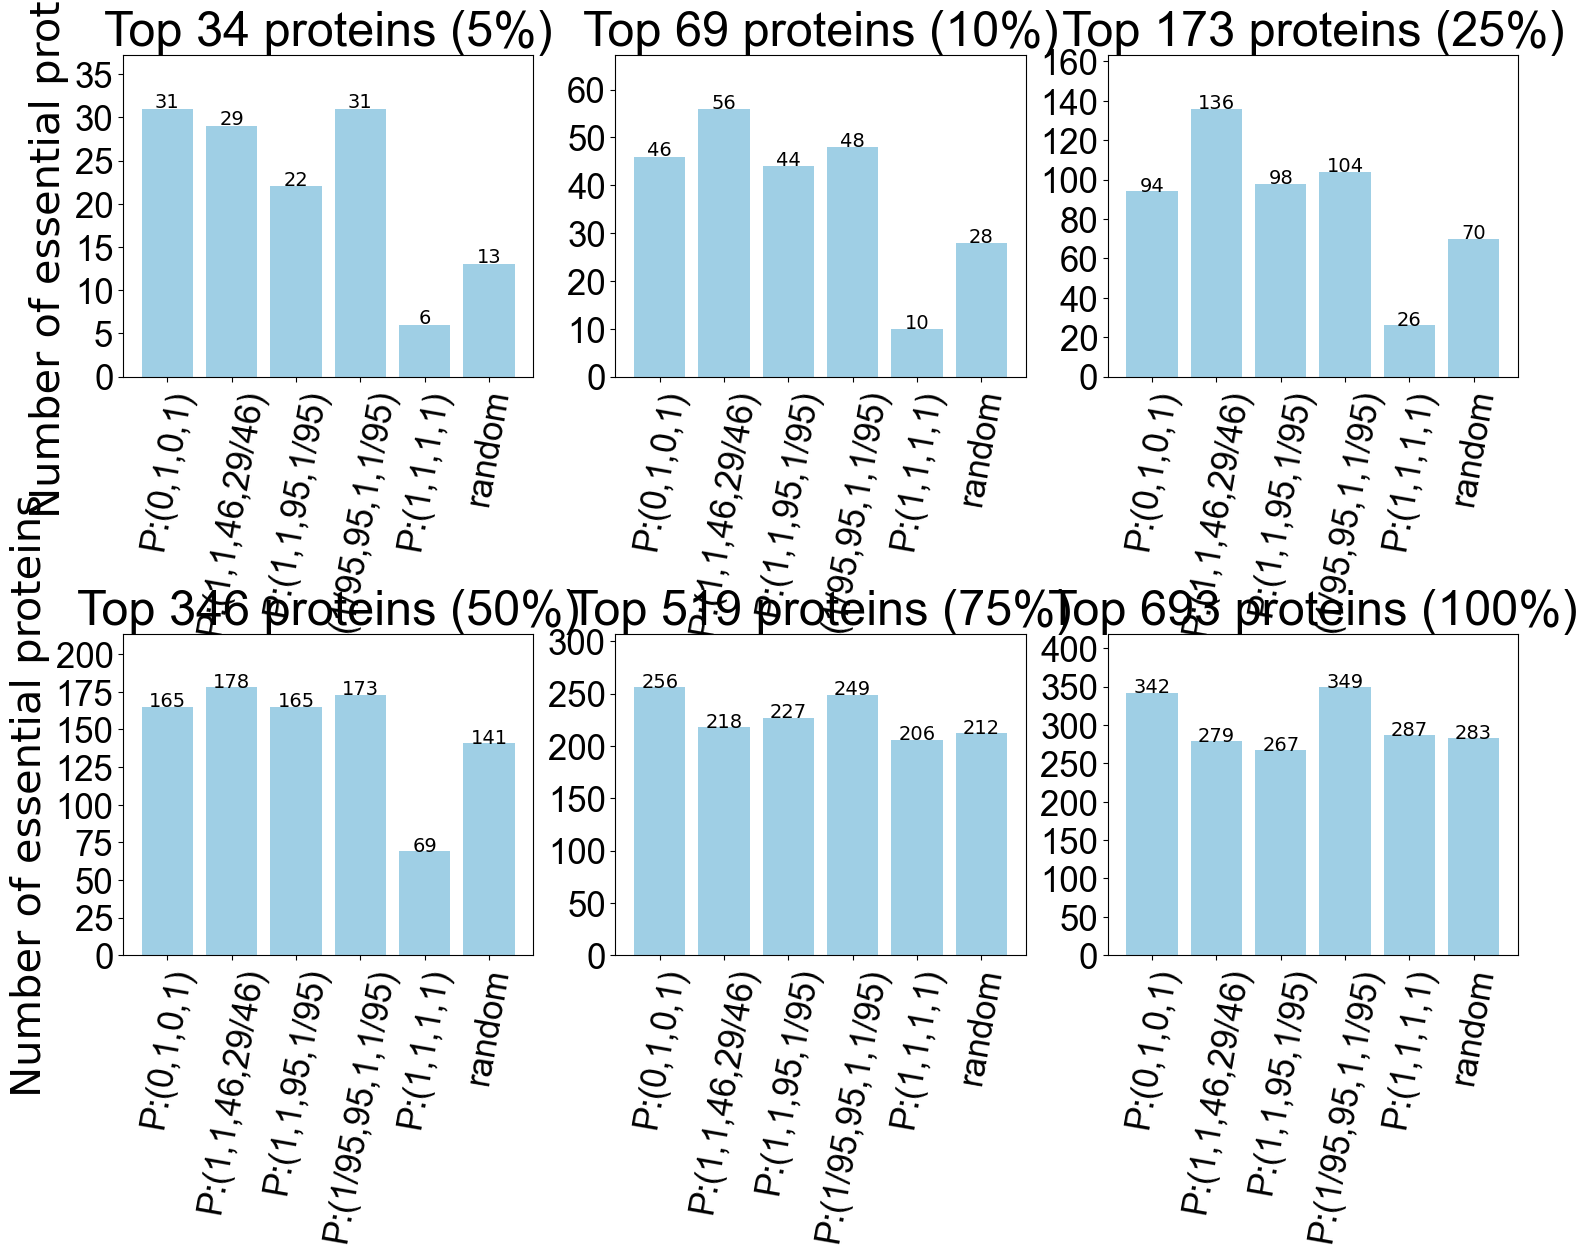

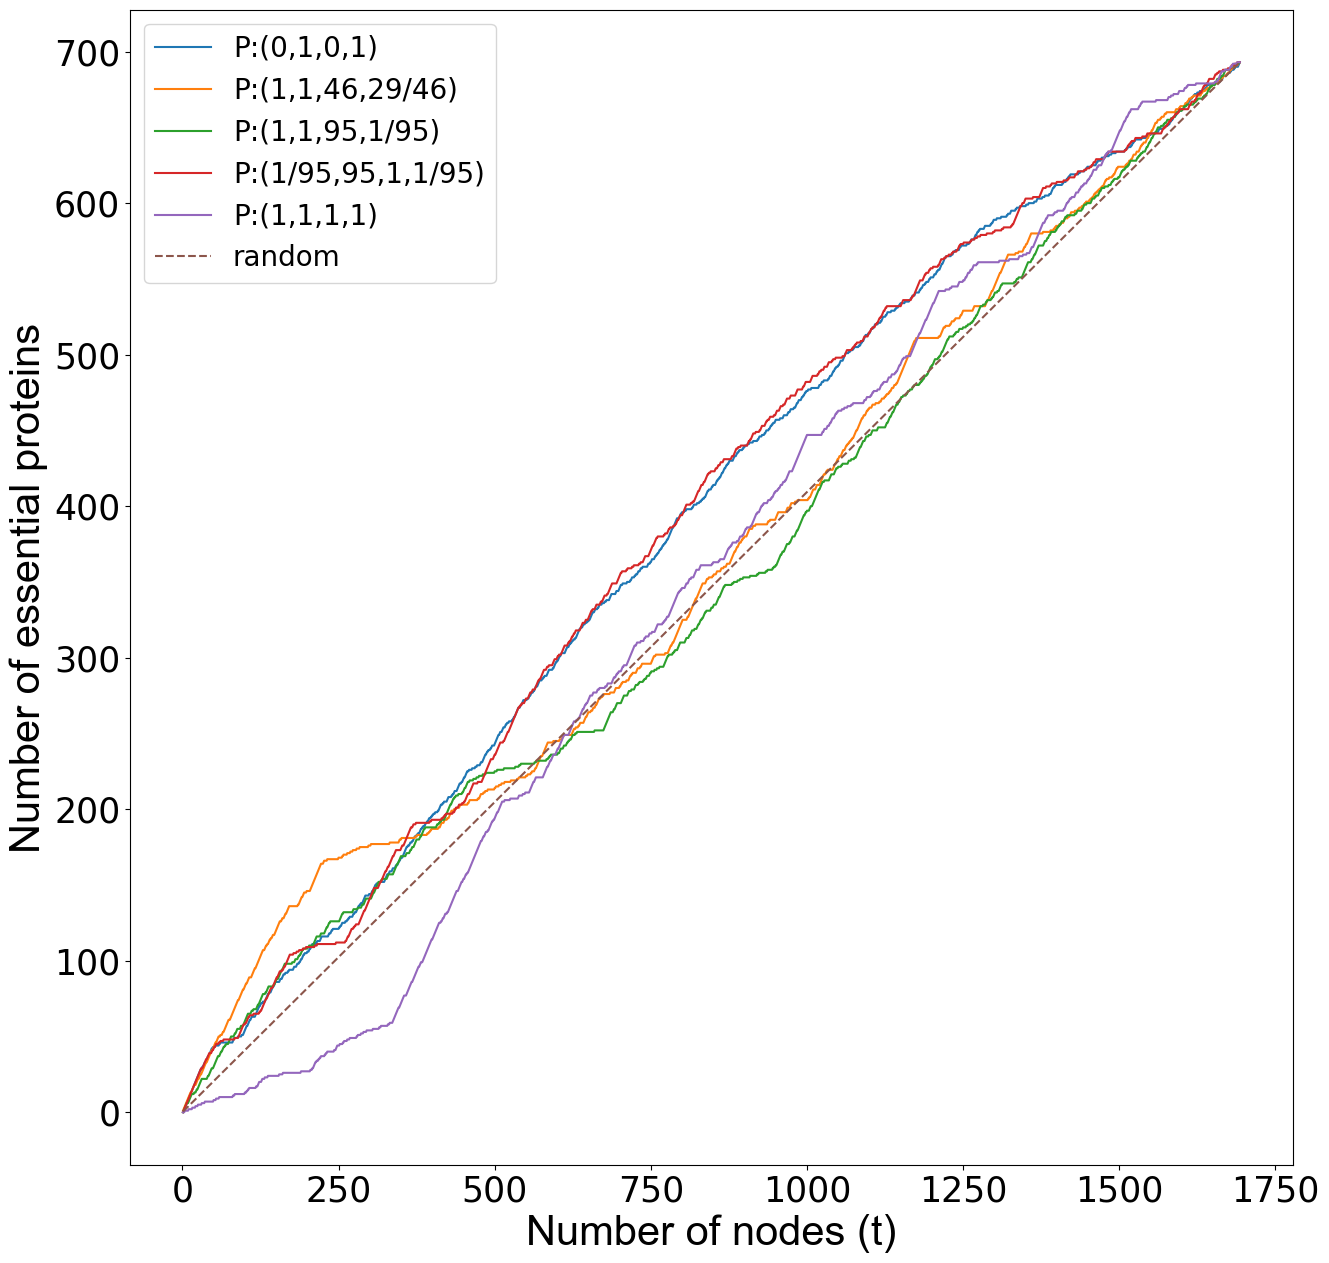

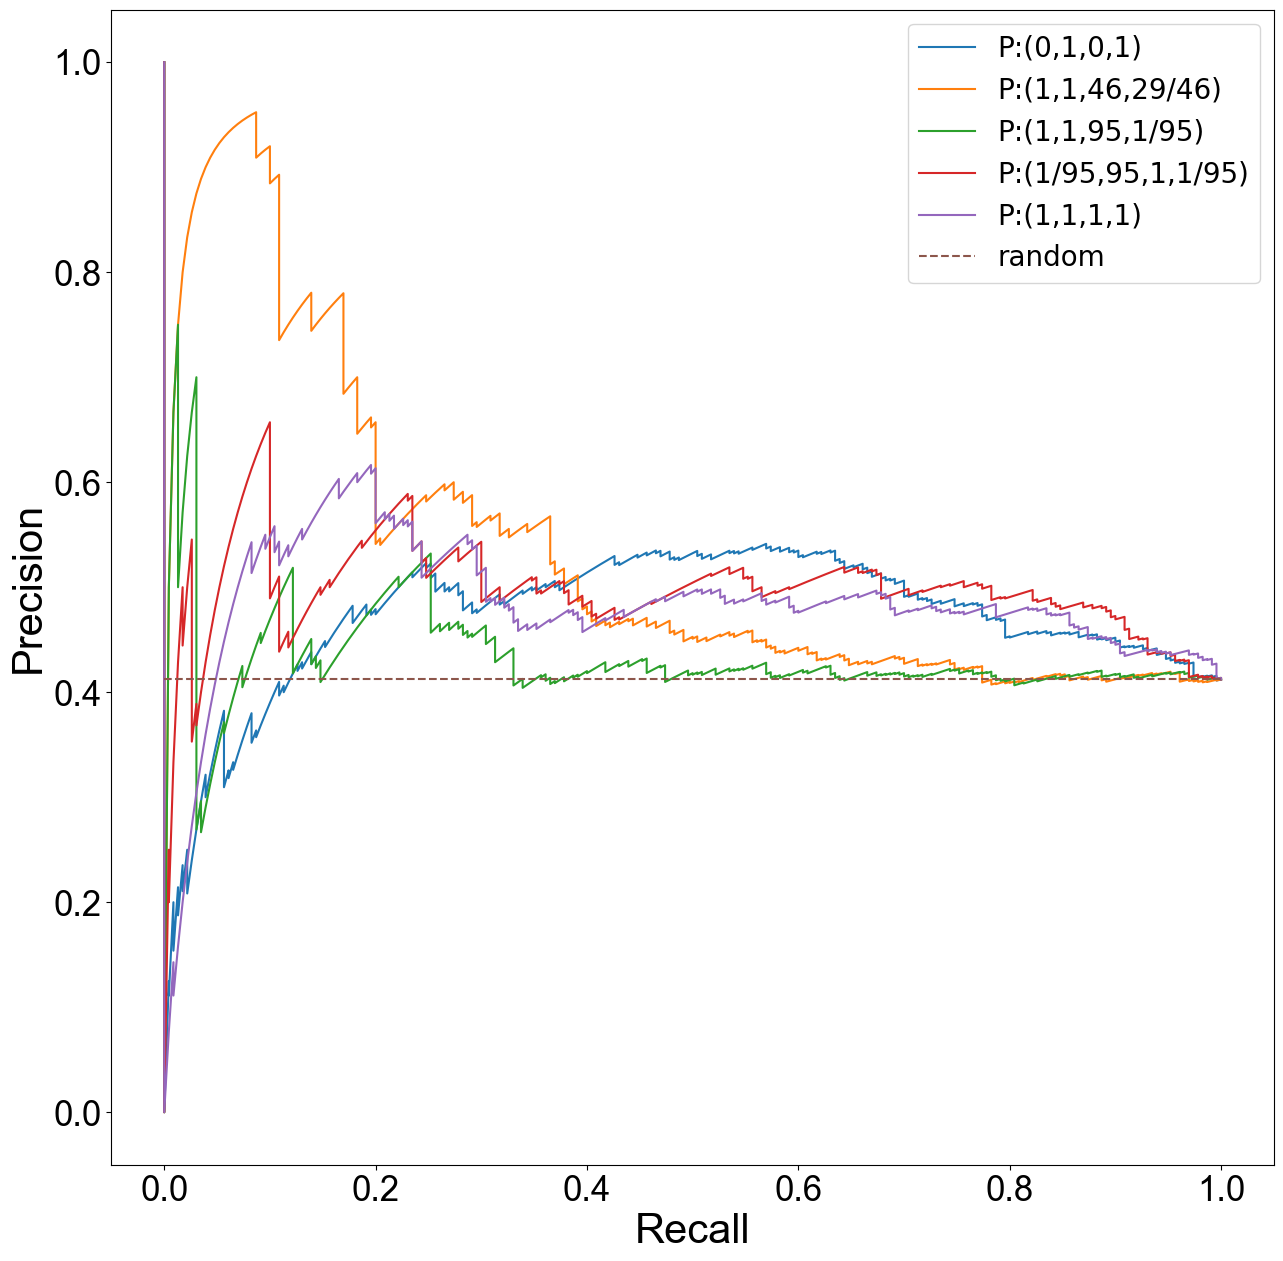

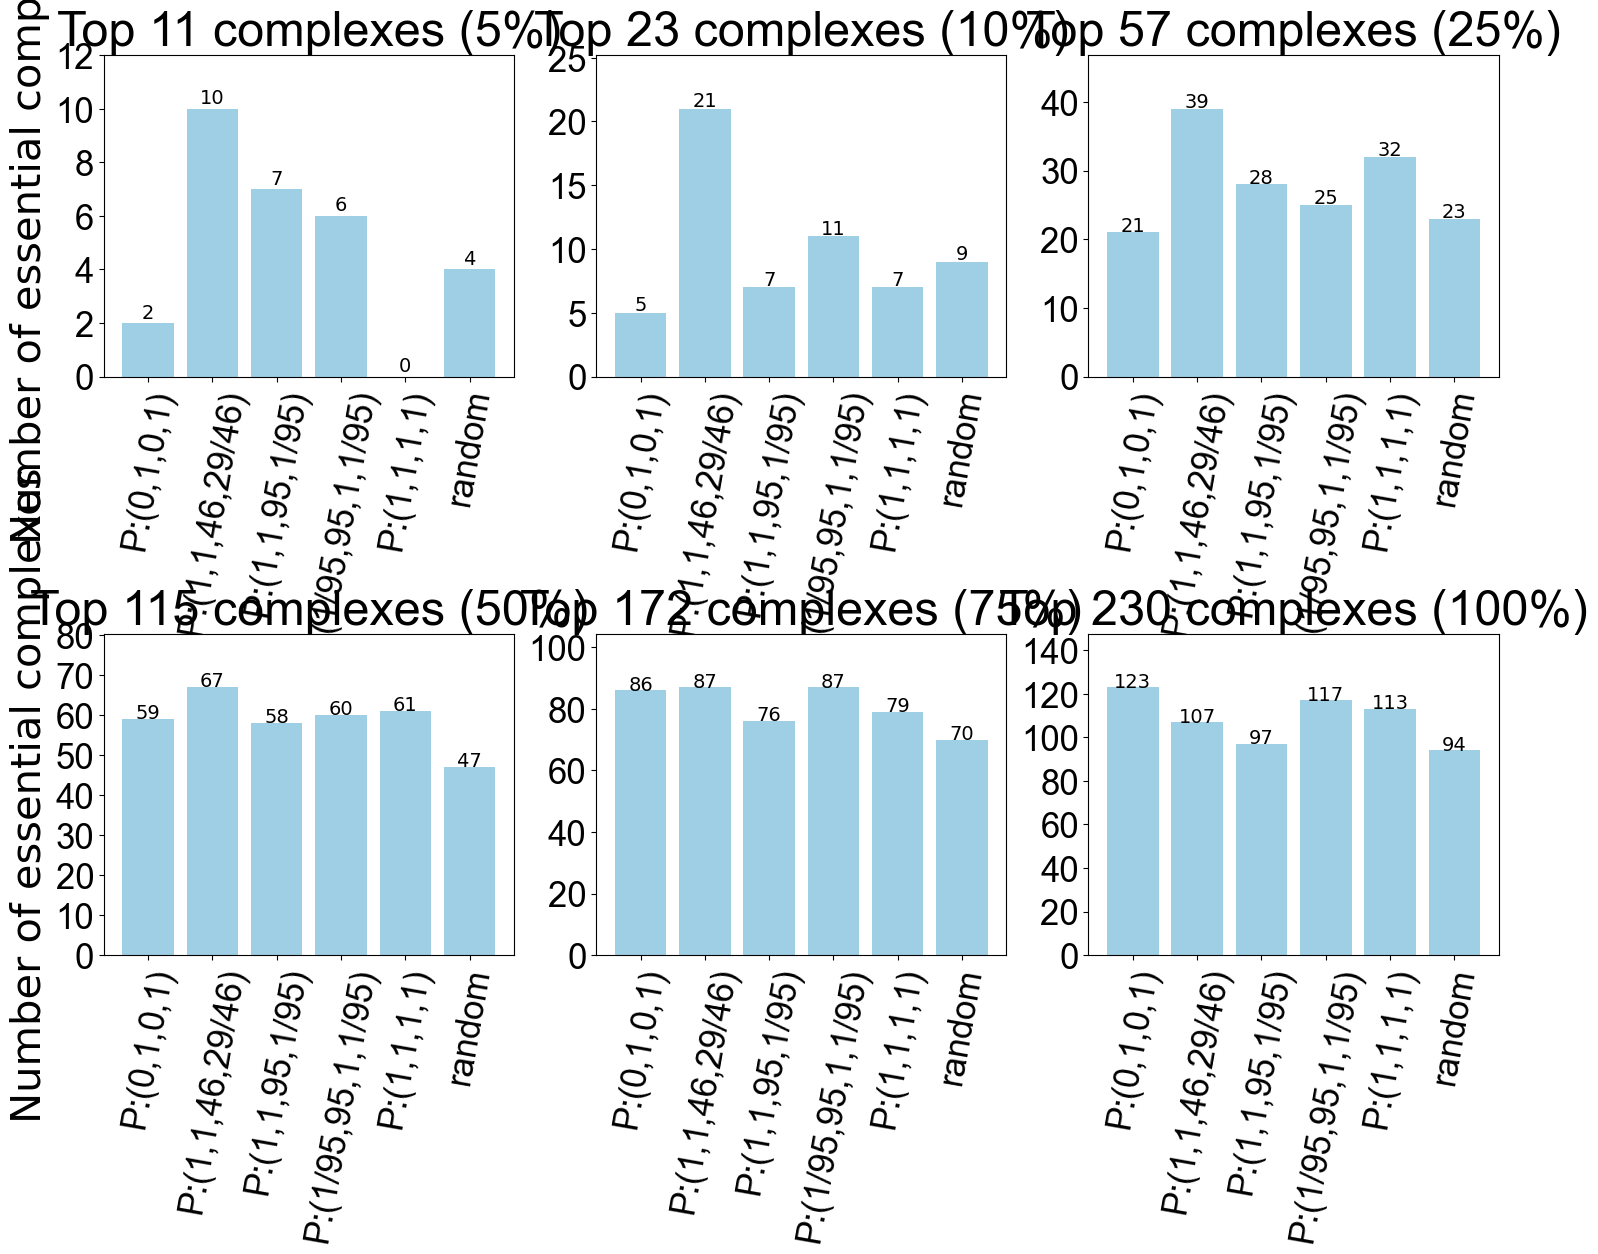

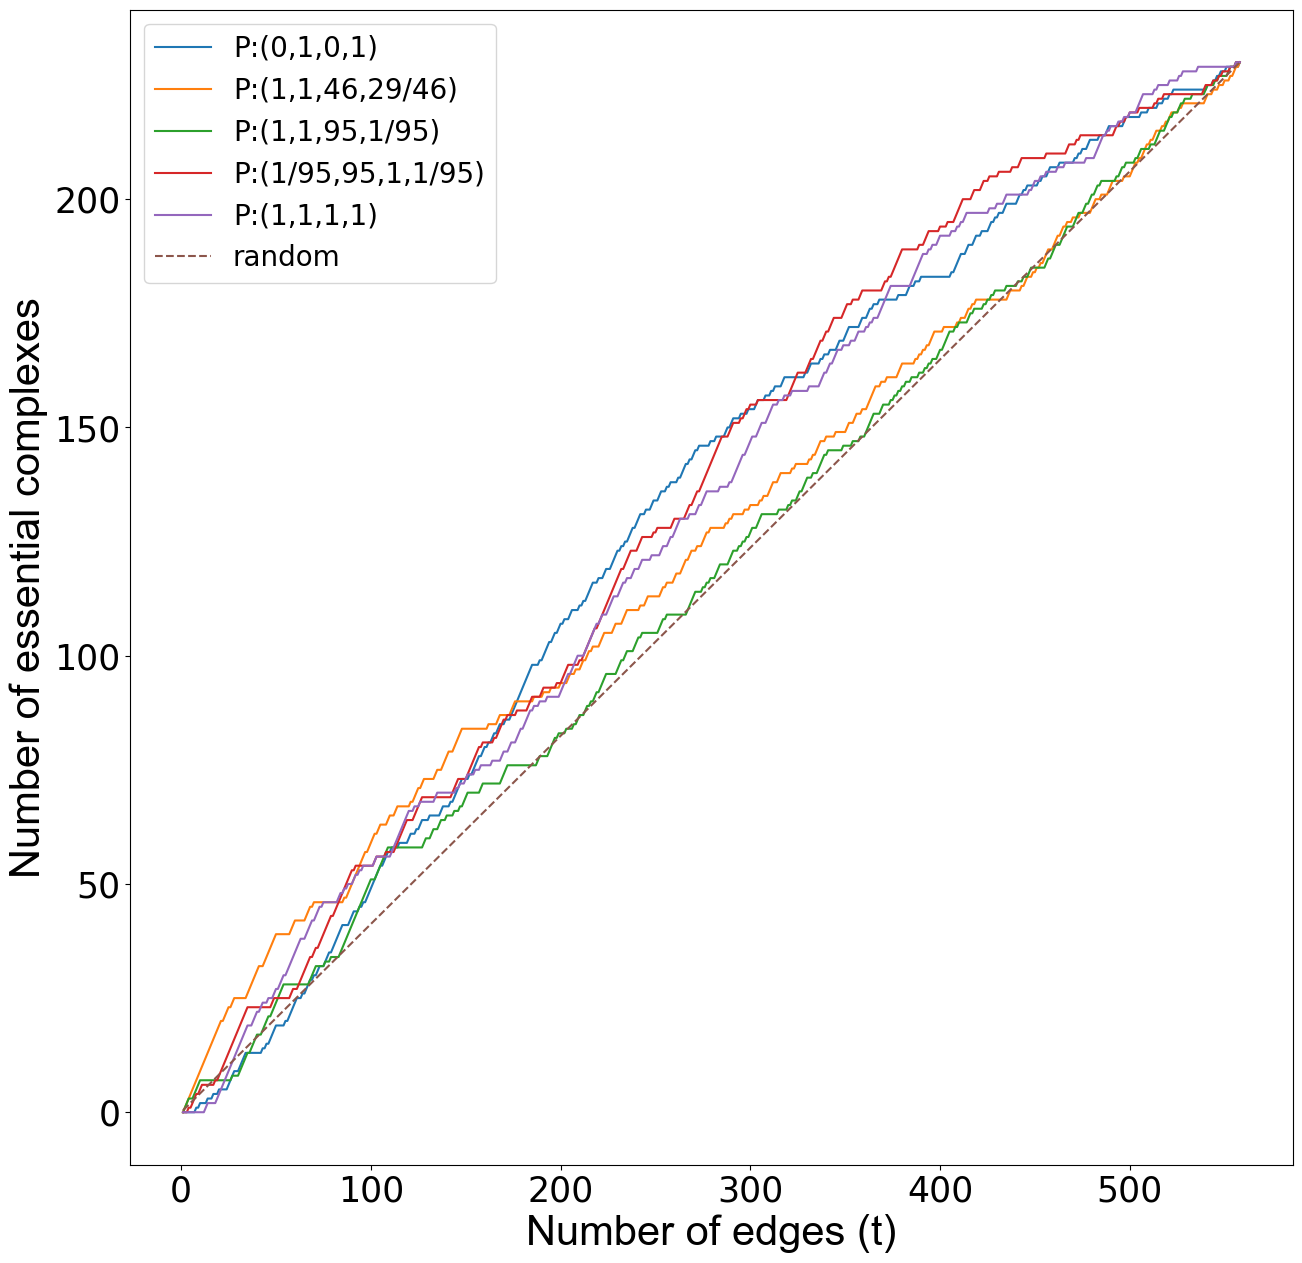

In [9]:
include("$file_path\\plot_functions.jl")
include("$file_path\\analysis_functions.jl") 
#print summary of maximum true positives for centralities


#comment out the following if centrality dictionary is large
# print summary of AUC and create plots

for cent_type in ["x", "y"]
    measures_dict = all_class_measures_plots(
        cent_type,
        centralities,
        deg_centralities,
        edge_deg_centralities,
        n_essent,
        n_non_essent,
        node_ess_dict,
        e_essent,
        e_non_essent,
        edge_ess_dict,
        percent_threshold,
        printlines = false,
        varying = varying,
    )
end